**Date** 23/11/2025
**Author** Jordi Torres
Core code based on work by professor Gaillard. 

**EXERCISE 1** Ayagari + employment status

In [1]:
#libraries 

using Printf;
using Roots;
using Plots;
using Distributions;

#wider page display
display("text/html", "<style>.container { width:100% !important; }</style>")

**Variables fixed**

In [2]:
const size_k 	= 1000;    #number of grid points     
const size_m 	= 7;       #number of productivity classes

const size_e =2 ; #added!

const kmin 		= 0.0;
const kmax 		= 1700.0;

betapar 	= 0.96;
const alphapar 	= 0.36;
const deltapar 	= 0.08;
const rhopar 	= 3.0;
const labor 	= 1.0219882;

const epsV    = 1.0e-6
const epsdist = 1.0e-8
const epsK    = 1.0e-6   # for debugging


## grid constants
const scale1 = 1.6;
const grmin = (kmin/scale1)-1.0;
const exponen=log((kmax/scale1)-grmin)/(size_k-1);

const sstates = [exp(-0.600000000000000)	  exp(-0.400000000000000)	  exp(-0.200000000000000)	  exp(0.000000000000000)	   exp(0.200000000000000)	   exp(0.400000000000000)	   exp(0.600000000000000)];

const strans = [	
    0.046746218637144	   0.217937777267117	   0.397822606398702	   0.266386738072197	   0.065169922261456	   0.005754191945237	   0.000182545418147;	
	0.023199661746751	   0.149524091076020	   0.369020347246402	   0.333823905199677	   0.110578117872631	   0.013276146769082	   0.000577730089437;	
	0.010548958644399	   0.093657511915497	   0.312761268311836	   0.382193227897354	   0.171253064028981	   0.027919224002876	   0.001666745199056;	
	0.004387354018187	   0.053538402796357	   0.242163972572887	   0.399820541225137	   0.242163972572887	   0.053538402796357	   0.004387354018187;	
	0.001666745199056	   0.027919224002876	   0.171253064028981	   0.382193227897354	   0.312761268311837	   0.093657511915497	   0.010548958644399;	
	0.000577730089436	   0.013276146769082	   0.110578117872631	   0.333823905199677	   0.369020347246403	   0.149524091076020	   0.023199661746751;	
	0.000182545418147	   0.005754191945237	   0.065169922261456	   0.266386738072197	   0.397822606398702	   0.217937777267117	   0.046746218637144];

#extension:

 b= 0.35
 tau_wage=0.25

const etrans = [
    0.45 0.55
    0.04 0.96
]

emplo = [0.0, 1.0]


2-element Vector{Float64}:
 0.0
 1.0

**Utility**

In [3]:
function utility(cons::Float64)
    cons_adj = max(cons, 1.0e-8)      
    return (cons_adj^(1.0-rhopar)) / (1.0 - rhopar)
end


function invmargutil(x::Float64)
    x_adj = max(x, 1.0e-12)     
    return x_adj^(-1.0/rhopar)
end


invmargutil (generic function with 1 method)

**Grid Manipulation functions**

In [4]:
function inter1d(x1::Float64,y1::Float64,y2::Float64) 
    return ((1.0-(x1))*(y1)+(x1)*(y2))
end

function getwage(rrate::Float64)
    return (1.0-alphapar)*(alphapar/(rrate+deltapar))^(alphapar/(1.0-alphapar));
end

function getlevel(igrid::Int64)
    #careful this function assumes that grid starts at 0
    return ( scale1*(exp(exponen*(igrid))+grmin) );
end

function getgrid(x::Float64)
    #careful because indexes start at 1 in Julia, a +1.0 was added
    return (log((x)/scale1-grmin)/exponen)+1.0;
end

getgrid (generic function with 1 method)

**EGM derivative**

In [5]:
function nderiv(val1::Float64,val2::Float64,val3::Float64,x1::Float64,x2::Float64,x3::Float64) 
    return ((1.0 - (x3 - x2)/(x3 - x1))*((val3 - val2)/(x3-x2)) + ((x3 - x2)/(x3 - x1))*((val2 - val1)/(x2-x1)));
end

nderiv (generic function with 1 method)

In [6]:
function POLICY_we(valueF::Array{Float64,3},dvalueF::Array{Float64,3},save::Array{Float64,3},wagerate::Float64,rrate::Float64, grid::Array{Float64}, betapar::Float64, tau_wage::Float64, b::Float64)

    aendo  = zeros(Float64, size_k, size_m, size_e);
    EVendo = zeros(Float64, size_k, size_m, size_e);  

    iter=0;

    critV=10000.0;

    while critV>epsV

        # we need copy to make a separate object
        valueFnew = copy(valueF);

        # COMPUTE EXPECTED VALUE / DERIVATIVE / ENDOGENEOUS GRID 
      @inbounds for iemplo::Int64 in 1:1:(size_e)  

            @inbounds Threads.@threads  for iprod::Int64 in 1:1:(size_m) #this is the s_t
                @inbounds for igrid::Int64 in 1:1:(size_k) #this is a' or a_t+1
                        
                    #writing the continuation value
                    tempnext  = 0.0;
                    dtempnext = 0.0;
                    @inbounds for iprodnext::Int64 in 1:1:(size_m) #this is the s_t+1
                        @inbounds for iemplonext::Int64 in 1:1:(size_e) #this is the s_t+1

                            ## next period expected value
                            tempnext  += strans[iprod,iprodnext]*etrans[iemplo,iemplonext]*valueF[igrid,iprodnext, iemplonext];

                            ## next period derivative 
                            dtempnext += strans[iprod,iprodnext]*etrans[iemplo,iemplonext]*dvalueF[igrid,iprodnext, iemplonext];

                            if dtempnext <= 0 || isnan(dtempnext)
                                @printf("ERROR: dtempnext = %e at (igrid=%d, iprod=%d, iemplo=%d)\n",
                                dtempnext, igrid, iprod, iemplo)
                                error("Bad dtempnext")
                            end

                            



                        end 
                    end

                    # computing endogenous grid using the first order condition
                    aendo[igrid,iprod, iemplo]  = (invmargutil(betapar*dtempnext) + grid[igrid] - wagerate * (emplo[iemplo]+ b*(1-emplo[iemplo]))*(1-tau_wage)* sstates[iprod])/(1.0 + rrate);
                    EVendo[igrid,iprod, iemplo] = tempnext;

                end
            end
       end

        ## aendo[igrid,iprod]  -- endogenous grid of assets 
        ## atilde(a' = 1 , s) , ...,  atilde(a' = a_n , s) 
        
        ## aexo 
        ## grid[1], ... , grid[n]




        @inbounds for iemplo::Int64 in 1:1:(size_e) 

            # RESCALING STEP
            @inbounds Threads.@threads for iprod::Int64 in 1:1:(size_m) #current productivity state
                ilast=1;
                @inbounds for igrid::Int64 in 1:1:(size_k) #current level of assets 
                    
                    # build cohexo for simplicity
                    cohexo = (1.0 + rrate) * grid[igrid] + wagerate * sstates[iprod]*(emplo[iemplo]+ b*(1-emplo[iemplo]))*(1-tau_wage);


                    # case 1: borrowing constrained case
                    if grid[igrid] <= aendo[1,iprod, iemplo]

                        save[igrid,iprod, iemplo]   = grid[1];
                        evfnext = EVendo[1,iprod, iemplo];

                    else ## otherwise I am either in case 2 or case 3

                        ## This is an improvement because we do not need to restart from scratch (due to monotonicity). 
                        ## We start with the previous grid point solution.
                        itest=ilast;  

                        # case 2: extrapolation case
                        if grid[igrid] > aendo[size_k,iprod, iemplo]
                            ## extrapolation so vfweight > 1
                            vfweight = (grid[igrid]-aendo[size_k-1,iprod, iemplo])/(aendo[size_k,iprod, iemplo]-aendo[size_k-1,iprod, iemplo]);
                            igridL   = size_k-1;
                            igridH   = size_k;
                        else

                            #finding interpolating points on cohendo
                            while ((itest<(size_k+1)&&(grid[igrid]>aendo[itest,iprod, iemplo])))
                                itest+=1;
                            end
                            
                            ## some sanity checks
                            if itest>(size_k+1)
                                @printf("itest>(size_k+1)");
                                exit()
                            end

                            # standard interior case
                            if itest==1
                                @printf("itest==1");
                                exit()
                            end

                            vfweight = (grid[igrid]-aendo[itest-1,iprod, iemplo])/(aendo[itest,iprod, iemplo]-aendo[itest-1,iprod, iemplo]);
                            igridL   = itest-1;
                            igridH   = itest;

                        end

                        ## linear interpolation of the value function and saving function using above weights and indexes
                        evfnext = inter1d(vfweight,EVendo[igridL,iprod, iemplo],EVendo[igridH,iprod, iemplo]);
                        save[igrid,iprod, iemplo] = inter1d(vfweight,grid[igridL],grid[igridH]);                    

                        ilast = min(size_k-1,itest);

                    end

                    ## construct the new VF
                    valueF[igrid,iprod, iemplo] = utility(cohexo-save[igrid,iprod, iemplo]) + betapar * evfnext;

                end
            end
        end 










        # computing new derivatives and convergence
        critV=0.0;
        @inbounds for iemplo::Int64 in 1:1:(size_e)
            @inbounds Threads.@threads for iprod::Int64 in 1:1:(size_m)
                @inbounds for igrid::Int64 in 1:1:(size_k)
            
                    # interior deriv
                    if (igrid>=3)
                        dvalueF[igrid-1,iprod, iemplo]=nderiv(valueF[igrid-2,iprod, iemplo],valueF[igrid-1,iprod, iemplo],valueF[igrid,iprod, iemplo],grid[igrid-2],grid[igrid-1],grid[igrid]);
                    end

                    critV=max(critV,abs(valueF[igrid,iprod, iemplo]-valueFnew[igrid,iprod, iemplo]));

                    # left corner
                    dvalueF[1,iprod, iemplo]=(valueF[2,iprod, iemplo]-valueF[1,iprod, iemplo])/(grid[2]-grid[1]);

                    # right corner
                    dvalueF[size_k,iprod, iemplo]=(valueF[size_k,iprod, iemplo]-valueF[size_k-1,iprod, iemplo])/(grid[size_k]-grid[size_k-1]);
        
                end
            end
        end 
        iter+=1;
         #@printf("CNVG %4d\t%20.15f\n",iter,critV);

    end
    

end

POLICY_we (generic function with 1 method)

**Simulation** $\rightarrow$ General Equilibrium!!!

In [7]:
function SIMULATION_we(save::Array{Float64,3},dist::Array{Float64,3},grid::Array{Float64})

    distold = zeros(Float64, size_k, size_m, size_e);

    critdist=1.0;
    while critdist>epsdist

        distold=copy(dist);
        fill!(dist, 0.0);

        @inbounds for iemplo::Int64 in 1:1:(size_e)
        # distribution dynamics
            @inbounds for iprod::Int64 in 1:1:(size_m)
                @inbounds for igrid::Int64 in 1:1:(size_k)
                    if distold[igrid,iprod, iemplo]>0

                        ## find index of saving value on the grid of assets/employment + associated weights
                        isave = min(floor(Int64, getgrid(save[igrid,iprod, iemplo])),size_k-1);
                        weight = (save[igrid,iprod, iemplo]-grid[isave])/(grid[isave+1]-grid[isave]);
                        @inbounds for iemplonext in 1:1:(size_e) 
                        # apply the mass to the new grid points.
                            @inbounds for iprodnext::Int64 in 1:1:(size_m)
                                dist[isave,iprodnext, iemplonext]               += (1.0-weight)*strans[iprod,iprodnext]*etrans[iemplo, iemplonext]*distold[igrid,iprod, iemplo];
                                dist[min(isave+1,size_k),iprodnext, iemplonext] += (weight)*strans[iprod,iprodnext]*etrans[iemplo, iemplonext]*distold[igrid,iprod, iemplo];
                            end
                        end 

                    end

                end
             end
        end




        # check convergence
        critdist=0.0;
        distverif = 0.0;
        @inbounds for iemplo::Int64 in 1:1:(size_e)
            @inbounds for iprod::Int64 in 1:1:(size_m)
                @inbounds for igrid::Int64 in 1:1:(size_k)
                    critdist=(max(critdist,abs(dist[igrid,iprod,iemplo]-distold[igrid,iprod, iemplo]))) ;
                    distverif+=dist[igrid,iprod, iemplo];
                end
            end
        end 
        # @printf("SIM %20.15f\t%20.15f\n", critdist, distverif);
    end




    # computing aggregates

    #capital
    capitalout=0.0;
    @inbounds for iemplo::Int64 in 1:1:(size_e)
        @inbounds for iprod::Int64 in 1:1:(size_m)
            @inbounds for igrid::Int64 in 1:1:(size_k)
                capitalout+=dist[igrid,iprod, iemplo]*grid[igrid];
                # @printf("%d\t%d\t%20.15f\n",iprod,igrid,dist[igrid,iprod]);
            end
        end
    end 
    #Govt budget

  laborout=0.0;
    @inbounds for iemplo::Int64 in 1:1:(size_e)
        @inbounds for iprod::Int64 in 1:1:(size_m)
            @inbounds for igrid::Int64 in 1:1:(size_k)
                laborout+=dist[igrid,iprod, iemplo]*sstates[iprod]*(emplo[iemplo]);
                # @printf("%d\t%d\t%20.15f\n",iprod,igrid,dist[igrid,iprod]);
            end
        end
    end 

    # println(capitalout);
    # read(stdin, Char);

    return(capitalout, laborout);


end

SIMULATION_we (generic function with 1 method)

In [8]:
    valueF  = zeros(Float64, size_k, size_m, size_e);
    dvalueF = zeros(Float64, size_k, size_m, size_e);
    save    = zeros(Float64, size_k, size_m, size_e);
    dist    = zeros(Float64, size_k, size_m, size_e);

    grid    = Array{Float64}(undef, size_k);

    # nth = Threads.nthreads(); #print number of threads
    @printf("Aiyagari1994 using %d threads\n",Threads.nthreads());
    # read(stdin, Char);




    # tabulating main grid
    for i::Int64 in 0:1:(size_k-1)
        grid[i+1]=getlevel(i);
        # @printf("%d\t%20.15f\t%20.15f\n",i+1,getlevel(i),getgrid(getlevel(i)) );
    end


    # initial prices
    rrate    = 0.040237086402090;
    wagerate = getwage(rrate);


    # GUESS:: initializing value function (inceasing in k) and initial derivative
    for iemplo in 1:size_e
        for iprod in 1:size_m
            for igrid in 1:size_k
                a = getlevel(igrid-1)
                valueF[igrid, iprod, iemplo] = utility(wagerate*sstates[iprod]*(emplo[iemplo] + b*(1-emplo[iemplo]))*(1-tau_wage) + (1+rrate)*a)
            end
        end
    end

    # GUESS initial distribution init
    dist .= 0.0
    dist[1, ceil(Int, size_m/2), 2] = 1.0   # asset zero, middle s, employed

    
    ## COMPUTE derivative
    for iemplo::Int64 in 1:1:(size_e)
        for iprod::Int64 in 1:1:(size_m)
            for igrid::Int64 in 1:1:(size_k)

                # interior deriv
                if (igrid>=3)
                    dvalueF[igrid-1,iprod, iemplo]=nderiv(valueF[igrid-2,iprod, iemplo],valueF[igrid-1,iprod, iemplo],valueF[igrid,iprod, iemplo],grid[igrid-2],grid[igrid-1],grid[igrid]);
                end

                # left corner
                dvalueF[1,iprod, iemplo]=(valueF[2,iprod, iemplo]-valueF[1,iprod, iemplo])/(grid[2]-grid[1]);
                # right corner
                dvalueF[size_k,iprod, iemplo]=(valueF[size_k,iprod, iemplo]-valueF[size_k-1,iprod, iemplo])/(grid[size_k]-grid[size_k-1]);

            end
        end
    end 

    POLICY_we(valueF,dvalueF,save,wagerate,rrate, grid, betapar, tau_wage, b);
            
    capitalout, laborout=SIMULATION_we(save,dist,grid);

Aiyagari1994 using 1 threads


Mass of distribution = 0.9999999999978223
capitalout = 8.389328245154486
laborout = 0.952700858161083
dist I=0.9999999999978222


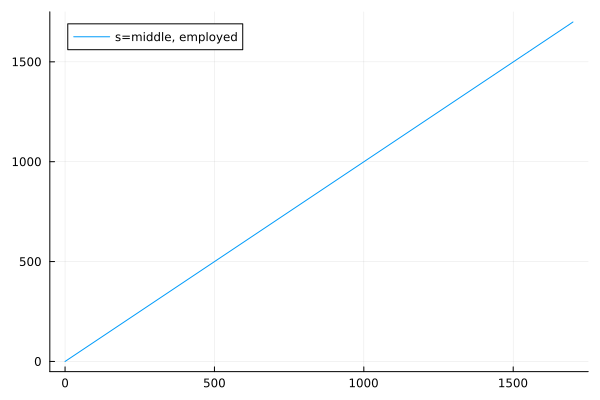

In [9]:
##sanity checks

println("Mass of distribution = ", sum(dist))
println("capitalout = ", capitalout)
println("laborout = ", laborout)

distI = dropdims(sum(dist, dims=(2,3)), dims=(2,3))  # sum over s,e
println("dist I=", sum(distI))

using Plots
plot(grid, save[:, 4, 2], label="s=middle, employed")




**Extend to General equilibrium**

In [10]:
const relaxsK 	= 0.01;


In [11]:
# functions for the equilibrium wage.
function getwage_eq(LABOR::Float64,CAPITAL::Float64)
    return (1.0-alphapar) * getGDP(LABOR,CAPITAL)/LABOR;
end

# function for the equilibrium interest rate. 
function getrate_eq(LABOR::Float64,CAPITAL::Float64)
    return (alphapar) * getGDP(LABOR,CAPITAL)/CAPITAL - deltapar;
end

 # functions for the equilibrium.
function getGDP(LABOR::Float64,CAPITAL::Float64)
    return (LABOR^(1.0-alphapar)) * (CAPITAL^(alphapar));
end

getGDP (generic function with 1 method)

In [12]:

function main_ge(betapar::Float64,impose_budget_balance::Bool, b::Float64)


    valueF  = zeros(Float64, size_k, size_m, size_e);
    dvalueF = zeros(Float64, size_k, size_m, size_e);
    save    = zeros(Float64, size_k, size_m, size_e);
    dist    = zeros(Float64, size_k, size_m, size_e);
    grid    = Array{Float64}(undef, size_k);

    # nth = Threads.nthreads(); #print number of threads
    @printf("Aiyagari1994 using %d threads\n",Threads.nthreads());
    # read(stdin, Char);




 # tabulating main grid
    for i::Int64 in 0:1:(size_k-1)
        grid[i+1]=getlevel(i);
        ##@printf("%d\t%20.15f\t%20.15f\n",i+1,getlevel(i),getgrid(getlevel(i)) );
    end



 # initial prices, gdp!!!
    LABOR   = 0.4
    CAPITAL = 2.60
    gdp= 0
    fixed_tau=0.25
    

    rrate    = getrate_eq(LABOR,CAPITAL);
    wagerate = getwage_eq(LABOR,CAPITAL);

    @printf("%f %f\n",rrate,wagerate);

 # distribution init
    dist .= 0.0
    dist[1, ceil(Int, size_m/2), 2] = 1.0   # asset zero, middle s, employed


    # === 1. Initialize value function ===
    for iemplo in 1:size_e
        for iprod in 1:size_m
            for igrid in 1:size_k
                a = grid[igrid]
                inc = wagerate * sstates[iprod] *
                    (emplo[iemplo] + b*(1-emplo[iemplo])) *
                    (1 - tau_wage)

                valueF[igrid, iprod, iemplo] = utility((1+rrate)*a + inc)
            end
        end
    end

    # === 2. Compute initial derivatives ===
    for iemplo in 1:size_e
        for iprod in 1:size_m

            # left
            dvalueF[1, iprod, iemplo] =
                (valueF[2,iprod,iemplo] - valueF[1,iprod,iemplo])/(grid[2]-grid[1])

            # interior
            for igrid in 3:size_k
                dvalueF[igrid-1, iprod, iemplo] =
                    nderiv(valueF[igrid-2,iprod,iemplo],
                        valueF[igrid-1,iprod,iemplo],
                        valueF[igrid,iprod,iemplo],
                        grid[igrid-2],grid[igrid-1],grid[igrid])
            end

            # right
            dvalueF[size_k, iprod, iemplo] =
                (valueF[size_k,iprod,iemplo] -
                valueF[size_k-1,iprod,iemplo])/(grid[end]-grid[end-1])
        end
    end

   @time begin
    ge_iter = 0
    max_ge_iter = 80

    critK = 1.0

    while critK > epsK && ge_iter < max_ge_iter
        ge_iter += 1

        t_iter_start = time()

        if (betapar*(1.0+rrate)>=1.0)
            println("Beta condition is not respected ",rrate," ",(betapar*(1.0+rrate)));
            exit();
        end



        ### pOLICY
        t_policy_start = time()
        POLICY_we(valueF, dvalueF, save, wagerate, rrate, grid, betapar, fixed_tau, b)
        t_policy = time() - t_policy_start


        ### Simul
        t_sim_start = time()
        SIMULATION_we(save, dist, grid)
        t_sim = time() - t_sim_start

        ### Aggregates

        # ! GOVT BUDGET CONSTRAINT 
            if impose_budget_balance ##This condition is set if we want to impose budget balance. 
                L_emp   = 0.0
                L_unemp = 0.0

                for iemplo in 1:size_e
                    for iprod in 1:size_m
                        for igrid in 1:size_k
                            mass = dist[igrid,iprod,iemplo]
                            s    = sstates[iprod]
                            e    = emplo[iemplo]

                            if e == 1
                                L_emp   += mass * s
                            else
                                L_unemp += mass * s
                            end
                        end
                    end
                end

                fixed_tau = b * L_unemp / L_emp
            end


        #Capital and labor

        capitalnew = 0.0
        labornew   = 0.0

        @inbounds for iemplo::Int in 1:size_e
            @inbounds for iprod::Int in 1:size_m
                @inbounds for igrid::Int in 1:size_k
                    capitalnew += dist[igrid,iprod,iemplo] * grid[igrid]
                    labornew   += dist[igrid,iprod,iemplo] * emplo[iemplo] * sstates[iprod]
                end
            end
        end

        # compute convergence
        wwage0 = wagerate
        rrate0 = rrate
        critK = abs((capitalnew - CAPITAL) / CAPITAL)

        # relaxation update
        CAPITAL = relaxsK * capitalnew + (1.0 - relaxsK) * CAPITAL
        LABOR   = relaxsK * labornew   + (1.0 - relaxsK) * LABOR

        # new prices
        rrate    = getrate_eq(LABOR, CAPITAL)
        wagerate = getwage_eq(LABOR, CAPITAL)
        gdp      = getGDP(LABOR, CAPITAL)



        t_iter = time() - t_iter_start

        ### === PRINT TIMERS AND RESULTS ===
        @printf("GE %3d | critK = %1.6e | t_policy = %4.3f s | t_sim = %4.3f s | t_iter = %4.3f s\n",
                ge_iter, critK, t_policy, t_sim, t_iter)

        @printf("         r=[%5f→%5f],  K=[%5f→%5f],  L=[%5f→%5f],  KY=%5f\n\n",
                rrate0, rrate, CAPITAL, capitalnew, LABOR, labornew, CAPITAL/gdp)

    end
 end



    distI = zeros(Float64, size_k);

    for iemplo::Int64 in 1:1:(size_e)
        for iprod::Int64 in 1:1:(size_m)
            for igrid::Int64 in 1:1:(size_k)
                distI[igrid] += dist[igrid,iprod, iemplo];
            end
        end
    end 


    welfare = 0.0
        for iemplo in 1:size_e
            for iprod in 1:size_m
                for igrid in 1:size_k
                    welfare += dist[igrid, iprod, iemplo] * valueF[igrid, iprod, iemplo]
                end
            end
        end

  return CAPITAL, LABOR, gdp,  dist, valueF, welfare, fixed_tau, rrate, wagerate
end



main_ge (generic function with 1 method)

In [13]:
   b_CAPITAL, b_LABOR, b_gdp,  dist, valueF, b_welfare, fixed_tau, b_rrate, b_wagerate= main_ge(betapar, false, b);

   ##fixed b, betapar, with the possibility to impose budget balance (if not, also use fixed tau_wage =0.25)

Aiyagari1994 using 1 threads
0.028652 1.255535
GE   1 | critK = 1.628614e-01 | t_policy = 1.463 s | t_sim = 0.054 s | t_iter = 1.518 s
         r=[0.028652→0.029725],  K=[2.595766→2.176560],  L=[0.405527→0.952701],  KY=3.280932

GE   2 | critK = 1.256482e-01 | t_policy = 0.848 s | t_sim = 0.057 s | t_iter = 0.906 s
         r=[0.029725→0.030759],  K=[2.592504→2.269612],  L=[0.410999→0.952701],  KY=3.250293

GE   3 | critK = 8.462904e-02 | t_policy = 0.849 s | t_sim = 0.063 s | t_iter = 0.913 s
         r=[0.030759→0.031752],  K=[2.590310→2.373103],  L=[0.416416→0.952701],  KY=3.221423

GE   4 | critK = 3.925151e-02 | t_policy = 0.848 s | t_sim = 0.070 s | t_iter = 0.919 s
         r=[0.031752→0.032699],  K=[2.589293→2.488636],  L=[0.421779→0.952701],  KY=3.194345

GE   5 | critK = 1.110138e-02 | t_policy = 0.838 s | t_sim = 0.074 s | t_iter = 0.913 s
         r=[0.032699→0.033597],  K=[2.589581→2.618038],  L=[0.427088→0.952701],  KY=3.169099

GE   6 | critK = 6.720420e-02 | t_policy = 

(3.9748567127828136, 0.705354393864554, 1.3144269429226467, [5.562174206445567e-7 4.830876142650465e-6 … 2.8092274463814803e-6 2.3711753362203878e-7; 8.141366681814882e-8 7.454181906896476e-7 … 5.730829284646327e-7 5.208190330985293e-8; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 7.622638646315204e-7 6.288763627956785e-6 … 3.4436484210573472e-6 2.901322596475836e-7; 1.8645331931592762e-7 1.4255553697992363e-6 … 7.386284246386283e-7 6.528034556282223e-8; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], [-39.20654628149482 -33.0651142078506 … -22.12481518941815 -20.83995406381644; -37.12566565756863 -31.903316893720145 … -21.995515723194337 -20.75059100657638; … ; -0.002803102786495765 -0.002802823432161723 … -0.0028012964583573924 -0.0028007714979914806; -0.002764692101557155 -0.002764418316838157 … -0.0027629217405010322 -0.002762407214694491;;; -20.152845820686732 -19.22006961444135 … -16.40745623469162 -15.73169340065396; -20.057855190973726 -19.161729134584768 … -16.38463016028495 -15.711

In [14]:
function check_budget_balance(dist, wage, tau_wage)

    L_emp   = 0.0
    L_unemp = 0.0

    for iemplo in 1:size_e
        for iprod in 1:size_m
            for igrid in 1:size_k
                mass = dist[igrid, iprod, iemplo]
                s    = sstates[iprod]
                e    = emplo[iemplo]   # 0 or 1

                if e == 1.0
                    L_emp   += mass * s
                else
                    L_unemp += mass * s
                end
            end
        end
    end

    tax_revenue = tau_wage * wage * L_emp
    ui_spending = b * wage * L_unemp

    println("=== Government budget check ===")
    println("  tau_wage       = ", tau_wage)
    println("  L_emp          = ", L_emp)
    println("  L_unemp        = ", L_unemp)
    println("  Tax revenue    = ", tax_revenue)
    println("  UI expenditures= ", ui_spending)
    println("  Diff (T-UI)    = ", tax_revenue - ui_spending)
    println("  Rel diff       = ", (tax_revenue - ui_spending) / max(abs(ui_spending), 1e-12))
end

check_budget_balance(dist, wagerate, fixed_tau)


=== Government budget check ===
  tau_wage       = 0.25
  L_emp          = 0.9527008581561324
  L_unemp        = 0.06928733513862802
  Tax revenue    = 0.2824717828833813
  UI expenditures= 0.028760763348126186
  Diff (T-UI)    = 0.25371101953525516
  Rel diff       = 8.821428571428543


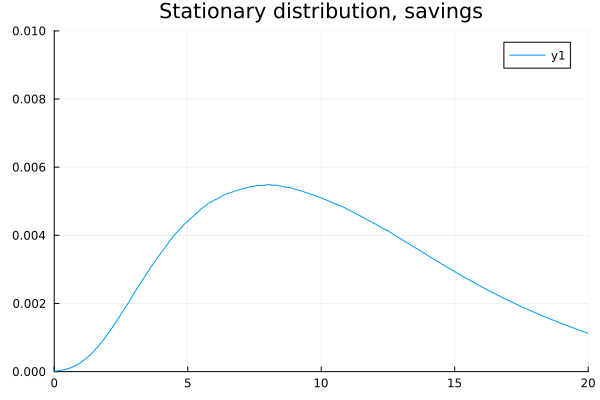

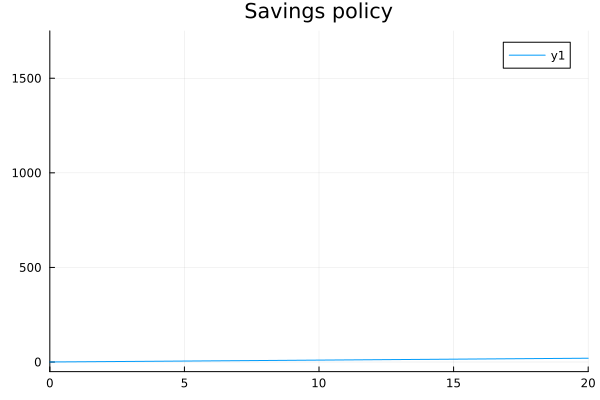

In [15]:
    display(plot(grid, distI, xlimits=(0,20), ylimits=(0,0.01),
                 title="Stationary distribution, savings"))

    display(plot(grid, save[:,ceil(Int,size_m/2),2],
                 xlimits=(0,20), title="Savings policy"))

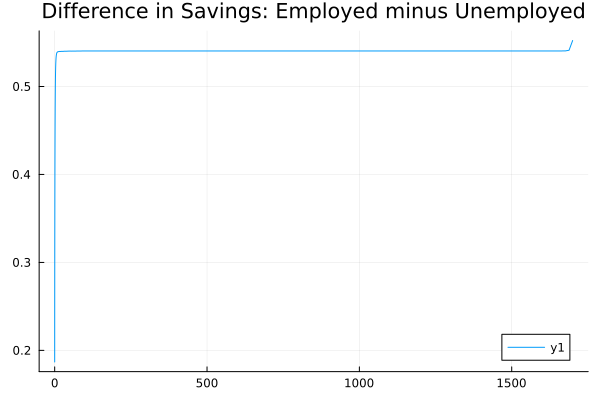

In [16]:
iprod = ceil(Int, size_m/2)

plot(grid, save[:,iprod,2] .- save[:,iprod,1],
    title="Difference in Savings: Employed minus Unemployed")



In [17]:
iprod = ceil(Int, size_m/2)
a = grid[500]

inc_emp   = wagerate * sstates[iprod] * (emplo[2] + b*(1-emplo[2])) * (1 - tau_wage)
inc_unemp = wagerate * sstates[iprod] * (emplo[1] + b*(1-emplo[1])) * (1 - tau_wage)

println("employed income = ", inc_emp)
println("unemployed income = ", inc_unemp)
println("ratio = ", inc_unemp / inc_emp)


employed income = 0.8894873363400143
unemployed income = 0.311320567719005
ratio = 0.35000000000000003


**Exercise 3** Calibrating the beta 

In [18]:
function compute_KY(beta)
    K, L, Y = main_ge(beta, false, b)   
    return K / Y
end


compute_KY (generic function with 1 method)

In [19]:
#bisection as suggested in Fabrice's notes/lecture
function calibrate_beta(KY_target; β_low = 0.90, β_high = 0.995, tol = 1e-3)

    max_iter = 50
    iter = 0

    while iter < max_iter
        iter += 1
        β_mid = 0.5 * (β_low + β_high)

        KY_mid = compute_KY(β_mid)
        diff = KY_mid - KY_target

        println("iter $iter: β =$β_mid   -> K/Y =$KY_mid   diff = $diff")

        if diff > 0
            β_high = β_mid
        else
            β_low = β_mid
        end

        #convergence check!
        if abs(diff) < tol
            return β_mid
        end
    end

    return betacalibrated=0.5 * (β_low + β_high)
end


calibrate_beta (generic function with 1 method)

In [20]:
beta_calibrated= calibrate_beta(3.2; β_low = 0.90, β_high = 0.995, tol=1e-3)

Aiyagari1994 using 1 threads
0.028652 1.255535
GE   1 | critK = 4.262749e-01 | t_policy = 1.090 s | t_sim = 0.029 s | t_iter = 1.120 s
         r=[0.028652→0.029911],  K=[2.588917→1.491685],  L=[0.405527→0.952701],  KY=3.275389

GE   2 | critK = 4.105580e-01 | t_policy = 0.759 s | t_sim = 0.024 s | t_iter = 0.784 s
         r=[0.029911→0.031150],  K=[2.578288→1.526016],  L=[0.410999→0.952701],  KY=3.238875

GE   3 | critK = 3.938964e-01 | t_policy = 0.666 s | t_sim = 0.027 s | t_iter = 0.694 s
         r=[0.031150→0.032369],  K=[2.568132→1.562709],  L=[0.416416→0.952701],  KY=3.203743

GE   4 | critK = 3.762215e-01 | t_policy = 0.682 s | t_sim = 0.030 s | t_iter = 0.712 s
         r=[0.032369→0.033566],  K=[2.558470→1.601946],  L=[0.421779→0.952701],  KY=3.169957

GE   5 | critK = 3.574400e-01 | t_policy = 0.665 s | t_sim = 0.030 s | t_iter = 0.696 s
         r=[0.033566→0.034742],  K=[2.549325→1.643971],  L=[0.427088→0.952701],  KY=3.137481

GE   6 | critK = 3.374280e-01 | t_policy = 

0.9665185546874999

**Exercise 4** Now we basically have to loop over possible values of b and set budget balance so that tau_wage also changes with the loop. 


3. Check welfare is well defined!!  -->this is the most importn
4. Write a loop over b that returns different values of tau_wage (include also as an output of the function)
5. Should we use the calibrated Beta from the previous exercise? should we enforce that-> I will 

In [21]:
function compute_cev(b_welfare, new_welfare, rhopar)

    CVE= (new_welfare/b_welfare)^(1/(1-rhopar))-1
    return CVE
end    

compute_cev (generic function with 1 method)

In [22]:
##This should be quite easy
function simulate_bpaths(b_grid, beta, b_welfare, rhopar)

    simul_results = zeros(length(b_grid), 3)

    @inbounds for igrid in 1:length(b_grid)

        b_simul = b_grid[igrid]

        print("Running b = $b_simul ($igrid/$(length(b_grid)))\n")
        flush(stderr)   
        flush(stdout)   

        CAPITAL, LABOR, gdp,  dist, valueF, welfare, fixed_tau= main_ge(beta, true, b_simul)

        CVE= compute_cev(b_welfare, welfare, rhopar)

        simul_results[igrid, 1] = b_simul
        simul_results[igrid, 2] = CVE
        simul_results[igrid, 3] = fixed_tau
    end

    return simul_results
end



simulate_bpaths (generic function with 1 method)

In [23]:
#comparing to baseline with budget balance too (fairest comparison, I would say)->now we are comparing bananas with bananas, citing professor Bobba.

b2_CAPITAL_wa, b2_LABOR_wa, b2_gdp_wa,  dist, valueF, b2_welfare_wa, fixed_tau= main_ge(beta_calibrated, true, b);





Aiyagari1994 using 1 threads
0.028652 1.255535
GE   1 | critK = 2.355032e-01 | t_policy = 1.726 s | t_sim = 0.131 s | t_iter = 1.858 s
         r=[0.028652→0.029446],  K=[2.606123→3.212308],  L=[0.405527→0.952701],  KY=3.289305

GE   2 | critK = 7.239176e-01 | t_policy = 1.525 s | t_sim = 0.168 s | t_iter = 1.694 s
         r=[0.029446→0.029880],  K=[2.624989→4.492742],  L=[0.410999→0.952701],  KY=3.276300

GE   3 | critK = 7.927136e-01 | t_policy = 0.888 s | t_sim = 0.148 s | t_iter = 1.037 s
         r=[0.029880→0.030246],  K=[2.645798→4.705854],  L=[0.416416→0.952701],  KY=3.265419

GE   4 | critK = 8.572618e-01 | t_policy = 0.866 s | t_sim = 0.162 s | t_iter = 1.029 s
         r=[0.030246→0.030547],  K=[2.668479→4.913939],  L=[0.421779→0.952701],  KY=3.256527

GE   5 | critK = 9.147994e-01 | t_policy = 0.841 s | t_sim = 0.173 s | t_iter = 1.015 s
         r=[0.030547→0.030788],  K=[2.692891→5.109603],  L=[0.427088→0.952701],  KY=3.249443

GE   6 | critK = 9.629121e-01 | t_policy = 

In [24]:
##apply function and define grid over b for which to loop over
b_grid = range(0.01, stop=0.99, step=0.03)

b_simul_2= simulate_bpaths(b_grid, beta_calibrated, b2_welfare_wa, rhopar)

Running b = 0.01 (1/33)
Aiyagari1994 using 1 threads
0.028652 1.255535
GE   1 | critK = 1.597894e+00 | t_policy = 1.684 s | t_sim = 0.182 s | t_iter = 1.867 s
         r=[0.028652→0.028504],  K=[2.641545→6.754525],  L=[0.405527→0.952701],  KY=3.317848

GE   2 | critK = 2.374500e+00 | t_policy = 1.495 s | t_sim = 0.191 s | t_iter = 1.687 s
         r=[0.028504→0.027807],  K=[2.704269→8.913893],  L=[0.410999→0.952701],  KY=3.339289

GE   3 | critK = 2.167766e+00 | t_policy = 0.936 s | t_sim = 0.141 s | t_iter = 1.078 s
         r=[0.027807→0.027233],  K=[2.762891→8.566492],  L=[0.416416→0.952701],  KY=3.357186

GE   4 | critK = 2.011672e+00 | t_policy = 0.913 s | t_sim = 0.124 s | t_iter = 1.038 s
         r=[0.027233→0.026745],  K=[2.818471→8.320921],  L=[0.421779→0.952701],  KY=3.372520

GE   5 | critK = 1.886792e+00 | t_policy = 0.907 s | t_sim = 0.111 s | t_iter = 1.019 s
         r=[0.026745→0.026324],  K=[2.871650→8.136340],  L=[0.427088→0.952701],  KY=3.385892

GE   6 | critK = 1.

Excessive output truncated after 524393 bytes.

GE  37 | critK = 6.781811e-01 | t_policy = 0.061 s | t_sim = 0.003 s | t_iter = 0.065 s
         r=[0.033168→0.033167],  K=[3.486641→5.811800],  L=[0.571642→0.952701],  KY=3.181129



33×3 Matrix{Float64}:
 0.01   0.00523741  0.000727273
 0.04   0.0045765   0.00290909
 0.07   0.00408782  0.00509091
 0.1    0.00366791  0.00727273
 0.13   0.00327341  0.00945455
 0.16   0.00288009  0.0116364
 0.19   0.00247993  0.0138182
 0.22   0.00206006  0.016
 0.25   0.00162233  0.0181818
 0.28   0.00116093  0.0203636
 ⋮                  
 0.73  -0.00677319  0.0530909
 0.76  -0.00716451  0.0552727
 0.79  -0.00752644  0.0574545
 0.82  -0.00785995  0.0596364
 0.85  -0.00817563  0.0618182
 0.88  -0.0084653   0.064
 0.91  -0.00875221  0.0661818
 0.94  -0.0090284   0.0683636
 0.97  -0.00930374  0.0705455

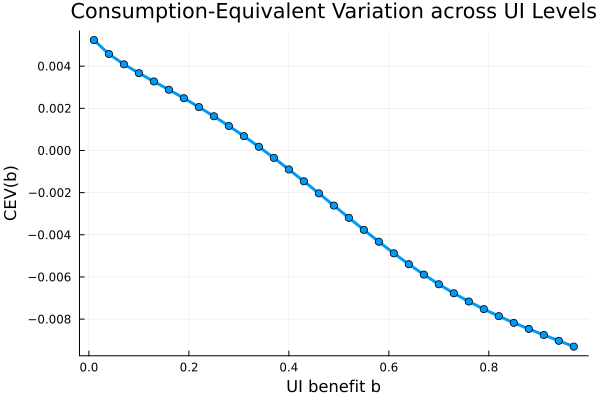

In [25]:
b      = b_simul_2[:, 1]
cev    = b_simul_2[:, 2]

plot(
    b, cev,
    xlabel = "UI benefit b",
    ylabel = "CEV(b)",
    title  = "Consumption-Equivalent Variation across UI Levels",
    legend = false,
    lw = 3,
    marker = :circle
)


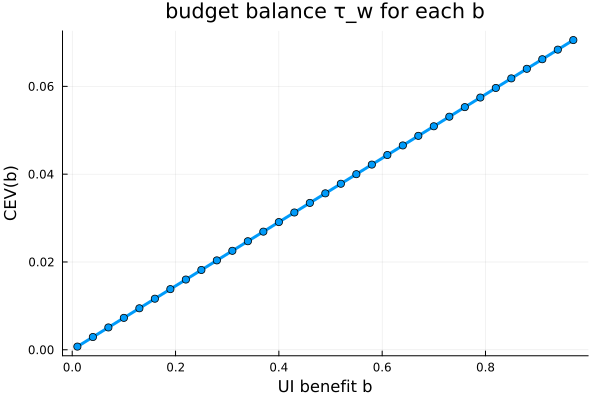

In [26]:
##add wages

b      = b_simul_2[:, 1]
wage    = b_simul_2[:, 3]

plot(
    b, wage,
    xlabel = "UI benefit b",
    ylabel = "CEV(b)",
    title  = "budget balance τ_w for each b",
    legend = false,
    lw = 3,
    marker = :circle
)

**Garbage**